**Problem :-**

The problem statement is as follows :-


*  Extract reviews of any product from ecommerce website like amazon
*  Perform emotion mining

The Emotion mining will be performed on most bought product(**SHASHIBO Shape Shifting Box**) on Amazon (refered from [Most Bought Product on Amazon](https://www.bestproducts.com/lifestyle/g3486/best-selling-products-on-amazon/) )

The reviews obtained by **Amazon Reviews Exporter | CSV & Images** Google Chrome Extention

In [1]:
import re
import nltk
import codecs
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer          # Library to find the base form of words. e.g running becomes run
from nltk.stem.porter import PorterStemmer       # Widely used and simple stemming algorithm.
from nltk.stem.snowball import SnowballStemmer   # Supports multiple languages while stemming the word to it's  root word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('reviews_extract.csv',usecols=['reviews.title','reviews.text','reviews.rating','dateAdded'])
df.head(3)

,dateAdded,reviews.rating,reviews.text,reviews.title
0,2016-03-08T20:21:53Z,5.0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!"
1,2016-03-08T20:21:53Z,5.0,Allow me to preface this with a little history...,One Simply Could Not Ask For More
2,2016-03-08T20:21:53Z,4.0,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader


In [3]:
df.columns = ['Date','rating','Review','title']
df.head(5)

,Date,rating,Review,title
0,2016-03-08T20:21:53Z,5.0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!"
1,2016-03-08T20:21:53Z,5.0,Allow me to preface this with a little history...,One Simply Could Not Ask For More
2,2016-03-08T20:21:53Z,4.0,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader
3,2016-03-08T20:21:53Z,5.0,I bought one of the first Paperwhites and have...,Love / Hate relationship
4,2016-03-08T20:21:53Z,5.0,I have to say upfront - I don't like coroporat...,I LOVE IT


In [4]:
df['Date'] = df['Date'].replace('T[0-9]{2}:[0-9]{2}:[0-9]{2}Z','',regex = True)
# leaving only the date information in the "Date" column (with the use of regular expression to identify Pattern)
df.head(10)

,Date,rating,Review,title
0,2016-03-08,5.0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!"
1,2016-03-08,5.0,Allow me to preface this with a little history...,One Simply Could Not Ask For More
2,2016-03-08,4.0,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader
3,2016-03-08,5.0,I bought one of the first Paperwhites and have...,Love / Hate relationship
4,2016-03-08,5.0,I have to say upfront - I don't like coroporat...,I LOVE IT
5,2016-03-08,NaN,"My previous kindle was a DX, this is my second...",Great device for reading. 8 people found this ...
6,2016-03-08,NaN,Allow me to preface this with a little history...,One Simply Could Not Ask For More 28 people fo...
7,2016-03-08,NaN,Just got mine right now. Looks the same as the...,Definitely better than the previous generation...
8,2016-03-08,NaN,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets! 16 people found..."
9,2016-03-08,NaN,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader 19 ...


In [5]:
df.shape

(1597, 4)

**Handling the 'NaN' Data** :- I will first determine which columns are  having null value and then will drop the rows having null value

---



In [6]:
df.isnull().sum()

Date        0
rating    420
Review      0
title      17
dtype: int64

In [7]:
df.dropna(subset=['rating','title'],inplace=True)
df.shape

(1177, 4)

In [8]:
df.isnull().sum()

Date      0
rating    0
Review    0
title     0
dtype: int64

In [9]:
df['rating'].describe()

count    1177.000000
mean        4.359388
std         1.021445
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 0 to 1596
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1177 non-null   object 
 1   rating  1177 non-null   float64
 2   Review  1177 non-null   object 
 3   title   1177 non-null   object 
dtypes: float64(1), object(3)
memory usage: 46.0+ KB


**Data Visualiztion** :- Plot between the Review Date and Number of reviews

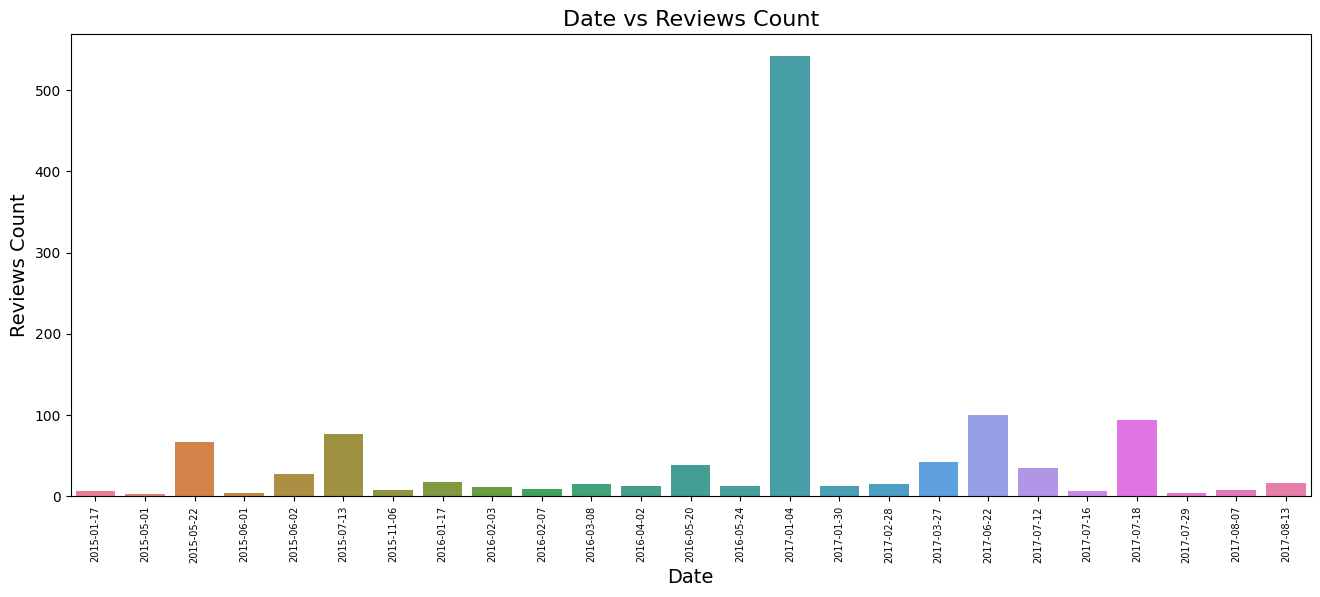

In [11]:
dayWise_review = pd.DataFrame(df.groupby('Date')['Review'].count()).reset_index()
dayWise_review.sort_values(by = ['Date'])
#Plotting the graph
plt.figure(figsize=(16,6))
sns.barplot(x = "Date", y = "Review", data = dayWise_review, hue='Date')
plt.title('Date vs Reviews Count', fontsize=16)
plt.xticks(rotation=90,fontsize=7)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Reviews Count',fontsize=14)
plt.show()

Percentage Distribution of Rating

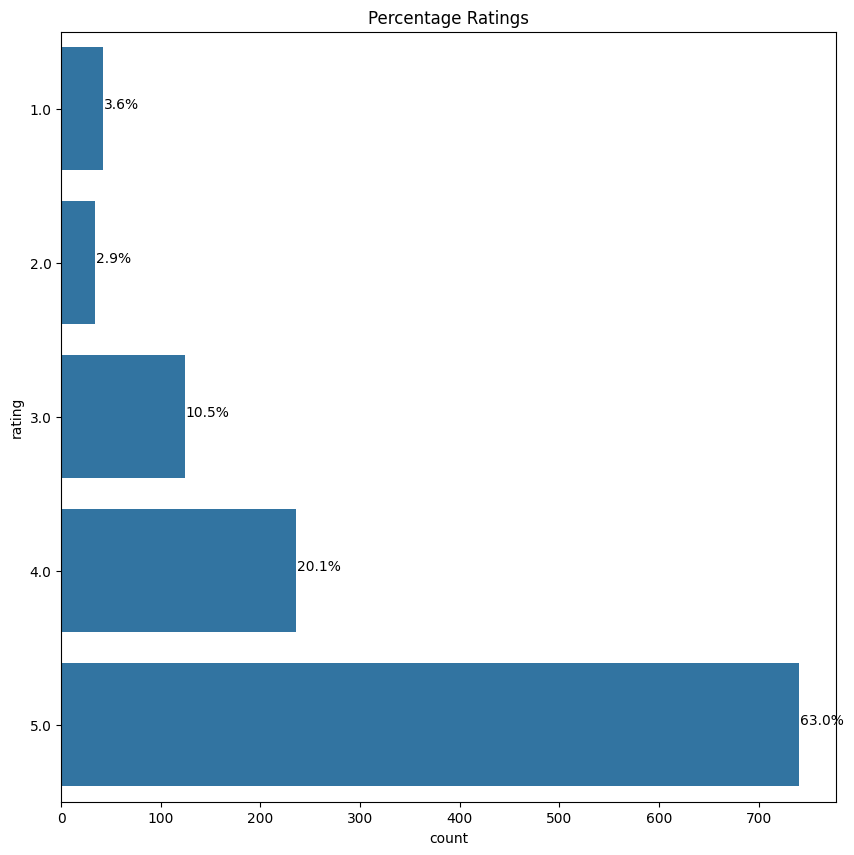

In [12]:
plt.figure(figsize=(10,10))
plt.title("Percentage Ratings")
ax = sns.countplot(y = 'rating',data = df)
total = len(df)
for p in ax.patches:
  percentage = '{:.1f}%'.format(100*p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.85
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x,y))

Basic Text Processing for Sentiment Analysis

* Identification of any possible spelling mistakes in review

---



In [13]:
df['Review'][:10].apply(lambda x:str(TextBlob(x).correct()))

0     I initially had trouble deciding between the p...
1     Allow me to preface this with a little history...
2     I am enjoying it so far. Great for reading. Ha...
3     I bought one of the first Paperwhites and have...
4     I have to say front - I don't like corporate, ...
13    Had older model, that you could text to speech...
14    His is a review of the Kindle Paperwhite launc...
15    I love my kindle! I got one for my fiance on h...
16    Raiment on petit apparel , her et face d emplo...
17    Exactly what it is supposed to be. Works great...
Name: Review, dtype: object

In [14]:
product_review = df[['Review']]
product_review.head(10)

,Review
0,I initially had trouble deciding between the p...
1,Allow me to preface this with a little history...
2,I am enjoying it so far. Great for reading. Ha...
3,I bought one of the first Paperwhites and have...
4,I have to say upfront - I don't like coroporat...
13,"Had older model, that you could text to speech..."
14,This is a review of the Kindle Paperwhite laun...
15,I love my kindle! I got one for my fiance on h...
16,"Vraiment bon petit appareil , lger et facile d..."
17,Exactly what it is supposed to be. Works great...


**Index Resting**

In [15]:
product_review.reset_index(drop = True, inplace = True)
product_review.head(10)

,Review
0,I initially had trouble deciding between the p...
1,Allow me to preface this with a little history...
2,I am enjoying it so far. Great for reading. Ha...
3,I bought one of the first Paperwhites and have...
4,I have to say upfront - I don't like coroporat...
5,"Had older model, that you could text to speech..."
6,This is a review of the Kindle Paperwhite laun...
7,I love my kindle! I got one for my fiance on h...
8,"Vraiment bon petit appareil , lger et facile d..."
9,Exactly what it is supposed to be. Works great...


**Removing Stopwords**

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
stop_words = stopwords.words('english')
product_review['Review'] = product_review['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop_words))
product_review.head()

,Review
0,i initially trouble deciding paperwhite voyage...
1,allow preface little history. i (was) casual r...
2,i enjoying far. great reading. had original fi...
3,i bought one first paperwhites pleased constan...
4,"i say upfront - i like coroporate, hermeticall..."


In [18]:
from tqdm import tqdm_notebook
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
lemmatizer = WordNetLemmatizer()
# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(product_review))):
    cleaned = re.sub('[^a-zA-Z]', " ", product_review["Review"][i])
    cleaned = cleaned.lower()
    cleaned = cleaned.split()
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/1177 [00:00<?, ?it/s]

In [20]:
#Saving cleaned data to compare with original data, to check amount of information lost
dataframe = pd.DataFrame({"Clean_Reviews": corpus,"Uncleaned_Reviews": product_review.Review})
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."


**Text Processing :-**

**A. Removing @names**

In [21]:
def drop_pattern(text, pattern_regex):
  p = re.findall(pattern_regex, text)
  for i in p:
        text = re.sub(i, '', text)
  return text

In [22]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
dataframe['Clean_Reviews'] = np.vectorize(drop_pattern)(dataframe['Clean_Reviews'], "@[\w]*")
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...


**B. Removing Links**

In [23]:
cleaned_reviews = []

for index, row in dataframe.iterrows():
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...


**C. Cleaning Empty Reviews**

In [24]:
dataframe = dataframe[dataframe['Clean_Reviews'] != '']
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...


**D. Drop Duplicates**

In [25]:
dataframe.drop_duplicates(subset = ['Clean_Reviews'],keep=False)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...


In [26]:
dataframe.shape

(1176, 2)

**E. Function to remove emoji's**

In [27]:
# pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 8.4 MB/s eta 0:00:00


In [28]:
import emoji

def remove_emojis(text):
    # Remove emojis using the emoji library
    cleaned_text = emoji.demojize(text)
    # Remove any residual emoji characters
    cleaned_text = ''.join(c for c in cleaned_text if c not in emoji.EMOJI_DATA)
    return cleaned_text

In [29]:
dir(emoji)

['EMOJI_DATA',
 'EmojiMatch',
 'EmojiMatchZWJ',
 'EmojiMatchZWJNonRGI',
 'LANGUAGES',
 'STATUS',
 'Token',
 '__all__',
 '__author__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__email__',
 '__file__',
 '__license__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__source__',
 '__spec__',
 '__version__',
 'analyze',
 'config',
 'core',
 'demojize',
 'distinct_emoji_list',
 'emoji_count',
 'emoji_list',
 'emojize',
 'get_aliases_unicode_dict',
 'get_emoji_unicode_dict',
 'is_emoji',
 'purely_emoji',
 'replace_emoji',
 'tokenizer',
 'unicode_codes',
 'version']

In [30]:
dataframe['Clean_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x:remove_emojis(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...


**F. Remove StopWords**

In [31]:
with codecs.open("stop.txt", "r", encoding="ISO-8859-1") as s:
    stop = s.read()
    print(stop[:101])

a
a's
able
about
above
according
accordingly
across
actually
after
afterwards
again
again


In [32]:
my_stop_words = stopwords.words('english')
sw_list = [stop]
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)
cleaned_tweets = []

for index, row in dataframe.iterrows():

    # filerting out all the stopwords
    words_without_stopwords = [word for word in row.Clean_Reviews.split() if not word in stopwords_set and '#' not in word.lower()]

    # finally creating tweets list of tuples containing stopwords(list) and sentimentType
    cleaned_tweets.append(' '.join(words_without_stopwords))

dataframe['Clean_Reviews'] = cleaned_tweets
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...


In [38]:
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...


**G. Tokenize Cleaned Reviews**

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
TextBlob(dataframe['Clean_Reviews'][0]).words

WordList(['initially', 'trouble', 'deciding', 'paperwhite', 'voyage', 'review', 'le', 'said', 'thing', 'paperwhite', 'great', 'spending', 'money', 'go', 'voyage', 'fortunately', 'friend', 'owned', 'ended', 'buying', 'paperwhite', 'basis', 'model', 'ppi', 'dollar', 'jump', 'turn', 'pricey', 'voyage', 'page', 'press', 'always', 'sensitive', 'fine', 'specific', 'setting', 'need', 'auto', 'light', 'adjustment', 'week', 'loving', 'paperwhite', 'regret', 'touch', 'screen', 'receptive', 'easy', 'use', 'keep', 'light', 'specific', 'setting', 'regardless', 'time', 'day', 'case', 'hard', 'change', 'setting', 'either', 'changing', 'light', 'level', 'certain', 'time', 'day', 'every', 'reading', 'also', 'glad', 'went', 'international', 'shipping', 'option', 'amazon', 'extra', 'expense', 'delivery', 'time', 'tracking', 'didnt', 'need', 'worry', 'custom', 'may', 'used', 'third', 'party', 'shipping', 'service'])

In [41]:
dataframe['Tokenized_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews,Tokenized_Reviews
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...,"[initially, trouble, deciding, paperwhite, voy..."
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...,"[allow, preface, little, history, casual, read..."
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...,"[enjoying, far, great, reading, original, fire..."
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...,"[bought, one, first, paperwhites, pleased, con..."
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall...","[say, upfront, like, coroporate, hermetically,..."
5,older model could text speech one liked smalle...,"had older model, could text speech, one hasn't...","[older, model, could, text, speech, one, liked..."
6,review kindle paperwhite launched july essenti...,this review kindle paperwhite launched july 20...,"[review, kindle, paperwhite, launched, july, e..."
7,love kindle got one fiance birthday loved deci...,"i love kindle! i got one fiance birthday, love...","[love, kindle, got, one, fiance, birthday, lov..."
8,vraiment bon petit appareil lger et facile emp...,"vraiment bon petit appareil , lger et facile e...","[vraiment, bon, petit, appareil, lger, et, fac..."
9,exactly supposed work great love built light p...,exactly supposed be. works great i love built-...,"[exactly, supposed, work, great, love, built, ..."


**H. Coverting the words into Stemmer**

In [42]:
stemmer = SnowballStemmer("english")

In [ ]:
xx = pd.DataFrame()
xx['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
xx

,stemmed
0,initi troubl decid paperwhit voyag review le s...
1,allow prefac littl histori casual reader own n...
2,enjoy far great read origin fire sinc fire use...
3,bought one first paperwhit pleas constant comp...
4,say upfront like coropor hermet close stuff li...
...,...
1172,remot got alexa echo control volum think remot...
1173,chang batteri remot twice per month sinc purch...
1174,remot activ connect box poor design remot repl...
1175,job super price feel like offer replac remot b...


**I. Convering words into Lemea**

In [43]:
word_lemmatizer = WordNetLemmatizer()
yy = pd.DataFrame()
yy['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([word_lemmatizer.lemmatize(i) for i in x.split()]))
yy

,stemmed
0,initially trouble deciding paperwhite voyage r...
1,allow preface little history casual reader own...
2,enjoying far great reading original fire since...
3,bought one first paperwhites pleased constant ...
4,say upfront like coroporate hermetically close...
...,...
1172,remote got alexa echo control volume think rem...
1173,change battery remote twice per month since pu...
1174,remote activate connect box poorly designed re...
1175,job super priced feel like offer replacement r...


**Basic Feature Extraction**

**A. Applying bag of Words without N grams**

In [ ]:
#dir(cv)

In [44]:
cv=CountVectorizer()
tweetscv=cv.fit_transform(dataframe.Clean_Reviews)
print(cv.get_feature_names_out()[109:200])

['aged' 'agenda' 'agent' 'agnostically' 'ago' 'agree' 'agreed' 'ah' 'aha'
 'ahead' 'ai' 'ailment' 'aim' 'air' 'airplay' 'airreceiver' 'ala' 'alarm'
 'alaxala' 'album' 'alert' 'alex' 'alexa' 'alexas' 'alexia' 'alexis'
 'alezxa' 'algorithm' 'aligned' 'alldo' 'alleviate' 'alley' 'allotment'
 'allow' 'allowed' 'allowing' 'allows' 'almost' 'alone' 'along' 'already'
 'alright' 'also' 'altclick' 'altering' 'alternate' 'alternative'
 'although' 'aluminum' 'always' 'amazed' 'amazement' 'amazing' 'amazingly'
 'amazon' 'amazonbasics' 'amazondeducted' 'amazonmusicunlimited'
 'ambassador' 'ambient' 'amd' 'ameloriating' 'among' 'amount' 'amt'
 'analysis' 'anc' 'andespn' 'andhave' 'android' 'angle' 'announced'
 'announcement' 'annoy' 'annoyance' 'annoyed' 'annoying' 'another'
 'answer' 'answered' 'answering' 'antenna' 'anthropomorphized' 'anti'
 'anticipated' 'antutu' 'anybody' 'anymore' 'anyone' 'anything' 'anytime']


In [45]:
print(cv.get_feature_names_out()[:100])

['aa' 'abc' 'ability' 'abit' 'able' 'abovementioned' 'absolute'
 'absolutely' 'absorbs' 'abstained' 'ac' 'accent' 'accept' 'acceptable'
 'access' 'accessed' 'accessibility' 'accessible' 'accessing' 'accessory'
 'accident' 'accidental' 'acclaimed' 'accompanied' 'accomplished'
 'according' 'account' 'accumulative' 'accuracy' 'accurate' 'accurately'
 'accustomed' 'acer' 'achat' 'achieve' 'acknowledgement' 'acre' 'across'
 'act' 'acted' 'acting' 'action' 'activate' 'activated' 'activation'
 'active' 'activity' 'actor' 'actual' 'actually' 'ad' 'adapter' 'adaptes'
 'adapting' 'adaptive' 'adaptor' 'adapts' 'adb' 'add' 'added' 'adding'
 'addition' 'additional' 'additionally' 'address' 'addressed' 'addressing'
 'adele' 'adequate' 'adhering' 'adhesive' 'adjust' 'adjustable'
 'adjusting' 'adjustment' 'adjustmentpaperwhite' 'adjusts' 'admin' 'admit'
 'admittedly' 'adopter' 'adoptor' 'adore' 'adsyeah' 'adult' 'advanced'
 'advantage' 'adversely' 'advert' 'advertise' 'advertised' 'advertisement'
 'ad

In [46]:
print(tweetscv.toarray()[100:200])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Countvectorizer with N-grams (Bi-grams and Tri-grams)**

In [47]:
dataframe = dataframe.reset_index(drop=True)

In [48]:
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1176 [00:00<?, ?it/s]

In [50]:
corpus[:4]

['initi troubl decid paperwhit voyag review le said thing paperwhit great spend money go voyag fortun friend own end buy paperwhit basi model ppi dollar jump turn pricey voyag page press alway sensit fine specif set need auto light adjust week love paperwhit regret touch screen recept easi use keep light specif set regardless time day case hard chang set either chang light level certain time day everi read also glad went intern ship option amazon extra expens deliveri time track didnt need worri custom may use third parti ship servic',
 'allow prefac littl histori casual reader own nook simpl touch read harri potter seri girl dragon tattoo seri brave new world key titl fair say nook get much use mani other may gotten fast forward today full week new kindl paperwhit admit love kindl read let relat review love read back kindl invest experi receiv buy kindl simpli pay screen entir experi includ buy amazon read hunger game trilog shall move onto diverg seri soon thing nook hinder past year

In [51]:
len(corpus)

1176

Applying the Countvectorizer to create bag of words model

In [52]:
cv = CountVectorizer(max_features=1176,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [53]:
X.shape

(1176, 1176)

In [55]:
cv.get_feature_names_out()[:25]

array(['abil', 'abl', 'abl compar', 'abl compar higher', 'abl hear',
       'abl hear go', 'absolut', 'access', 'account', 'accur',
       'accur product', 'accur product address', 'activ', 'actual',
       'actual sound', 'actual sound bit', 'ad', 'adapt', 'add', 'addit',
       'address', 'address three', 'address three biggest', 'adjust',
       'ago'], dtype=object)

In [56]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 1176,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [57]:
count_df = pd.DataFrame(X,columns=cv.get_feature_names_out())
count_df

,abil,abl,abl compar,abl compar higher,abl hear,abl hear go,absolut,access,account,accur,...,year model,year old,year rare,year rare write,year recent,year recent use,year tinni,year tinni listen,yet,youtub
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**TF- IDF Vectorizer**

In [58]:
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1176 [00:00<?, ?it/s]

In [59]:
corpus[5]

'older model could text speech one like smaller size buy differ cover still get use shelf quit differ year old model paper white nice read'

**Applying the TF-IDF Vectorizer**

In [60]:
tfidf_v = TfidfVectorizer(max_features=1176,ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()

In [61]:
X.shape

(1176, 1176)

In [62]:
tfidf_v.get_feature_names_out()[:20]

array(['abil', 'abl', 'abl compar', 'abl compar higher', 'abl hear',
       'abl hear go', 'absolut', 'access', 'account', 'accur',
       'accur product', 'accur product address', 'activ', 'actual',
       'actual sound', 'actual sound bit', 'ad', 'adapt', 'add', 'addit'],
      dtype=object)

In [63]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 1176,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [65]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df

,abil,abl,abl compar,abl compar higher,abl hear,abl hear go,absolut,access,account,accur,...,year model,year old,year rare,year rare write,year recent,year recent use,year tinni,year tinni listen,yet,youtub
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294063,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077792,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


**Named Entity Recognition**

In [67]:
reviews = [review.strip() for review in dataframe.Clean_Reviews]
reviews = [comment for comment in reviews if comment]
# Joining the list into one string/text
reviews_text = ' '.join(reviews)
reviews_text[:1000]

'initially trouble deciding paperwhite voyage review le said thing paperwhite great spending money go voyage fortunately friend owned ended buying paperwhite basis model ppi dollar jump turn pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regret touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad went international shipping option amazon extra expense delivery time tracking didnt need worry custom may used third party shipping service allow preface little history casual reader owned nook simple touch read harry potter series girl dragon tattoo series brave new world key title fair say nook get much use many others may gotten fast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment experience receive buy kindle simply paying scre

**Parts of Speech Tagging**

In [70]:
nlp = spacy.load('en_core_web_sm')

one_block = reviews_text[0:2000]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [71]:
for token in doc_block[:50]:
    print(token,token.pos_)

initially ADV
trouble NOUN
deciding VERB
paperwhite ADJ
voyage NOUN
review NOUN
le PROPN
said VERB
thing NOUN
paperwhite ADJ
great ADJ
spending NOUN
money NOUN
go VERB
voyage NOUN
fortunately ADV
friend NOUN
owned VERB
ended VERB
buying VERB
paperwhite ADJ
basis NOUN
model NOUN
ppi PROPN
dollar NOUN
jump NOUN
turn VERB
pricey ADJ
voyage NOUN
page NOUN
press NOUN
always ADV
sensitive ADJ
fine ADJ
specific ADJ
setting NOUN
need NOUN
auto NOUN
light NOUN
adjustment NOUN
week NOUN
loving VERB
paperwhite ADJ
regret NOUN
touch NOUN
screen NOUN
receptive ADJ
easy ADJ
use NOUN
keep VERB


**Filtering out the Nouns and Verbs**

In [72]:
nlp.max_length =  1500000
one_block=reviews_text
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['moving', 'series', 'hindered', 'year', 'inspired', 'pick', 'get', 'hand', 'dive', 'feeling', 'man', 'reading', 'thing', 'feeling', 'desire', 'adore', 'kindle', 'considering', 'purchasing', 'stop', 'thinking', 'go', 'week', 'downloaded', 'book', 'ton', 'reading', 'half', 'battery', 'left', 'make', 'inspire', 'reader', 'enjoying', 'reading', 'fire', 'fire', 'used', 'make', 'eye', 'hurt', 'read', 'experienced', 'bought', 'paperwhites', 'pleased', 'companion', 'suppose', 'read', 'book', 'day', 'year', 'give', 'pry', 'finger', 'reason', 'made', 'use', 'screen', 'usability', 'delivers', 'work', 'attraction', 'companion', 'like', 'critique', 'knew', 'coming', 'member', 'bookbub', 'get', 'list', 'alert', 'book', 'deal', 'chosen', 'take', 'found', 'world', 'keep', 'day', 'seems', 'book', 'read', 'bought', 'stuff', 'effect', 'number', 'book', 'creeping', 'time', 'mind', 'noticed', 'page', 'turning', 'remained', 'action', 'kindle', 'become', 'think']


**Counting the Nouns and Verbs**

In [73]:
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)

words_freq = [(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df = pd.DataFrame(words_freq)
wd_df.columns = ['word','count']
wd_df[0:10]

,word,count
0,fire,719
1,use,562
2,device,555
3,read,487
4,review,438
5,year,434
6,tablet,426
7,headphone,406
8,screen,394
9,work,384


**Visualization :- Top 10 most repeated nouns and verbs**

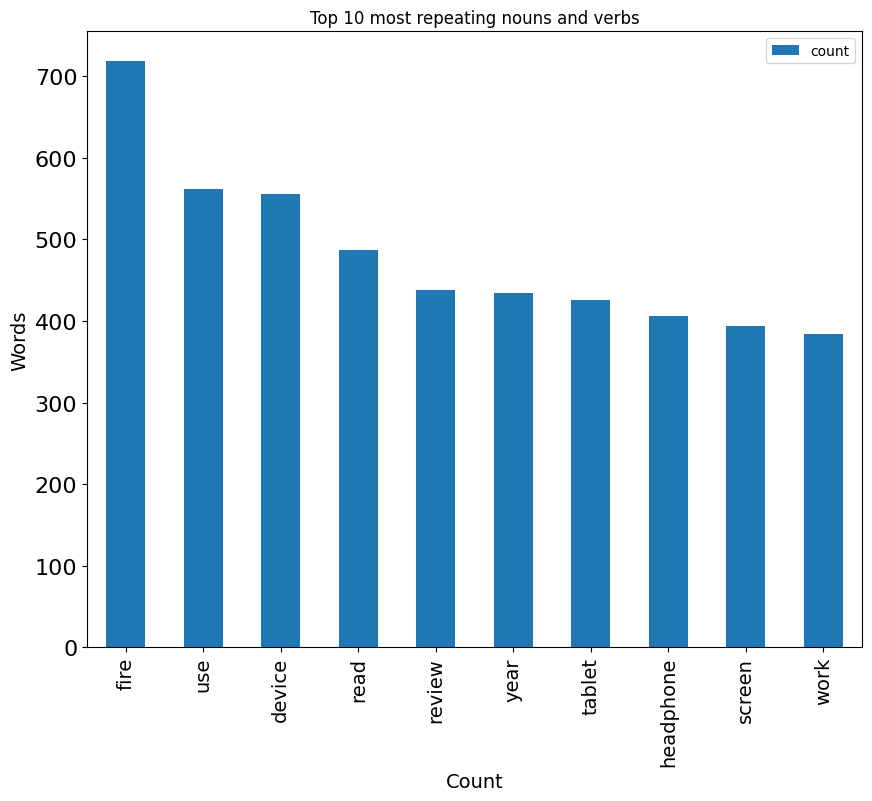

In [77]:
wd_df[0:10].plot.bar(x='word',figsize=(10,8),title='Top 10 most repeating nouns and verbs', fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.show()

**Feature Extraction**

A. BOW Features

In [78]:
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

B. TF-IDF Features

In [79]:
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

**Fetch sentiments Using TextBlob**

In [80]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [81]:
sentiments_using_textblob = dataframe.Clean_Reviews.apply(lambda reviews_text: fetch_sentiment_using_textblob(reviews_text))
pd.DataFrame(sentiments_using_textblob.value_counts())

,Clean_Reviews
pos,1113
neg,63


Negative Review very less compared to possitive ones which was expected as It is the most bought product on Amazon

**Let's now Calclate the subjectivity and the Polarity**

In [82]:
# Subjectivity calculation function
def cal_subj(text):
    return TextBlob(text).sentiment.subjectivity

# Polarity calculation function
def cal_pola(text):
    return TextBlob(text).sentiment.polarity

dataframe['Subjectivity'] = dataframe.Clean_Reviews.apply(cal_subj)
dataframe['Polarity'] = dataframe.Clean_Reviews.apply(cal_pola)
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews,Tokenized_Reviews,Subjectivity,Polarity
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...,"[initially, trouble, deciding, paperwhite, voy...",0.522024,0.231812
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...,"[allow, preface, little, history, casual, read...",0.495883,0.165502
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...,"[enjoying, far, great, reading, original, fire...",0.733333,0.420833
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...,"[bought, one, first, paperwhites, pleased, con...",0.424838,0.126867
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall...","[say, upfront, like, coroporate, hermetically,...",0.535215,0.310313


Scatter Plot between Subjectivity and Polarity

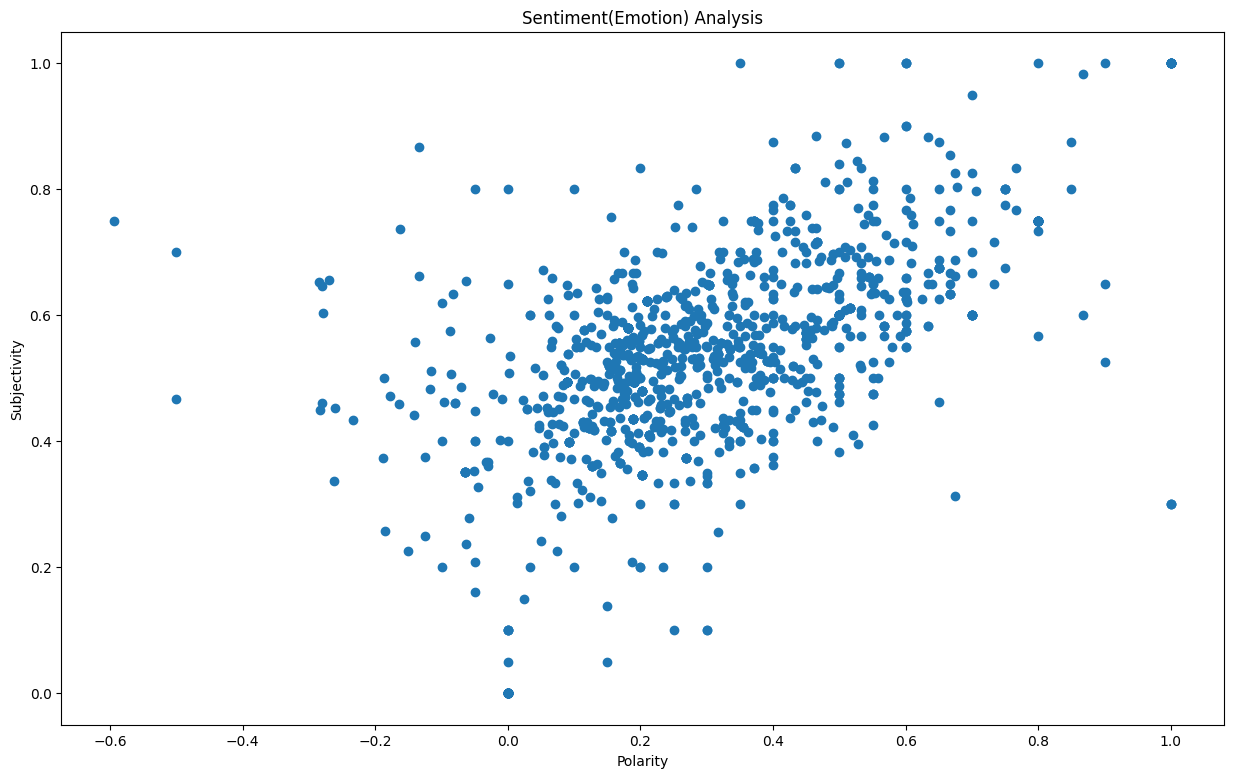

In [84]:
f, axes = plt.subplots(figsize = (15,9))
plt.scatter(dataframe.Polarity, dataframe.Subjectivity)
plt.title('Sentiment(Emotion) Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [85]:
dataframe['emotion'] = sentiments_using_textblob
dataframe.to_csv("clean_review.csv",index=False)
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews,Tokenized_Reviews,Subjectivity,Polarity,emotion
0,initially trouble deciding paperwhite voyage r...,i initially trouble deciding paperwhite voyage...,"[initially, trouble, deciding, paperwhite, voy...",0.522024,0.231812,pos
1,allow preface little history casual reader own...,allow preface little history. i (was) casual r...,"[allow, preface, little, history, casual, read...",0.495883,0.165502,pos
2,enjoying far great reading original fire since...,i enjoying far. great reading. had original fi...,"[enjoying, far, great, reading, original, fire...",0.733333,0.420833,pos
3,bought one first paperwhites pleased constant ...,i bought one first paperwhites pleased constan...,"[bought, one, first, paperwhites, pleased, con...",0.424838,0.126867,pos
4,say upfront like coroporate hermetically close...,"i say upfront - i like coroporate, hermeticall...","[say, upfront, like, coroporate, hermetically,...",0.535215,0.310313,pos


**Narrative creation and representation**

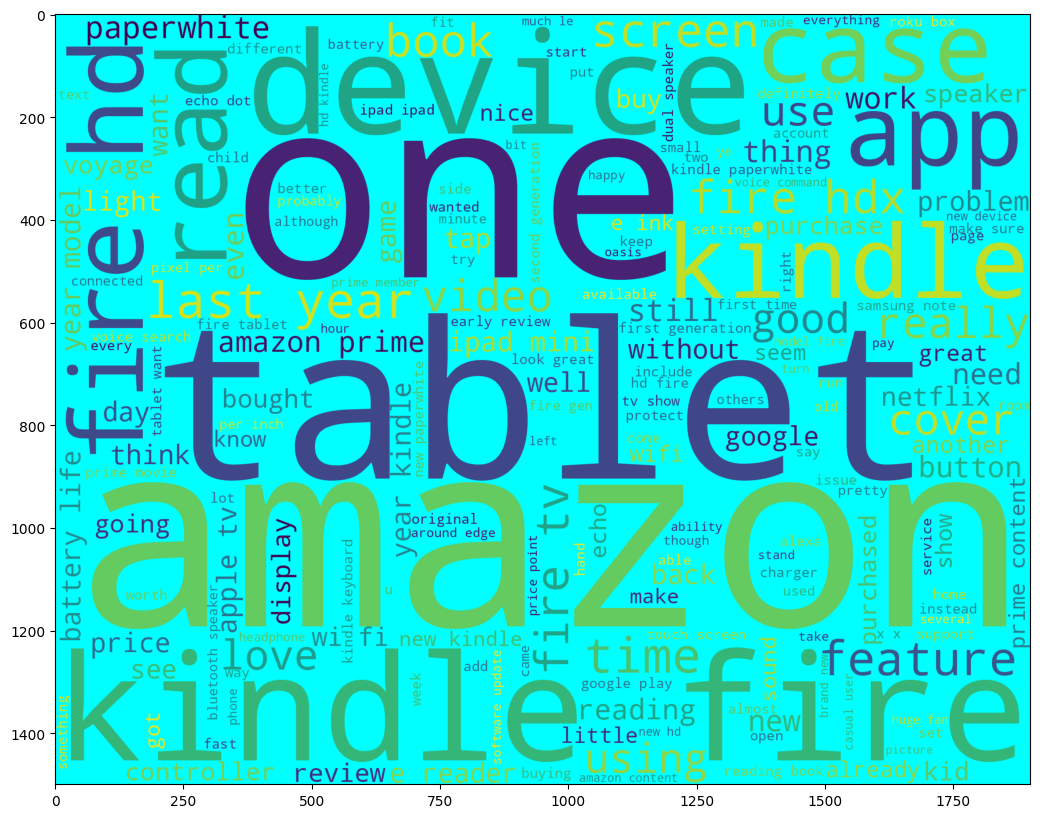

In [87]:
allWords_ = ' '.join([review for review in dataframe[:500]['Clean_Reviews']])
f, axes = plt.subplots(figsize=(14,10))
wordcloud= WordCloud(background_color = 'cyan', width = 1900, height =1500).generate(allWords_)
plt.imshow(wordcloud)
plt.show()

**Favorable feedback**

In [93]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(background_color = 'red',width=900, height=600, random_state=42, max_font_size=100, relative_scaling=0.5, colormap='plasma').generate(all_words)

    plt.figure(figsize=(14,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

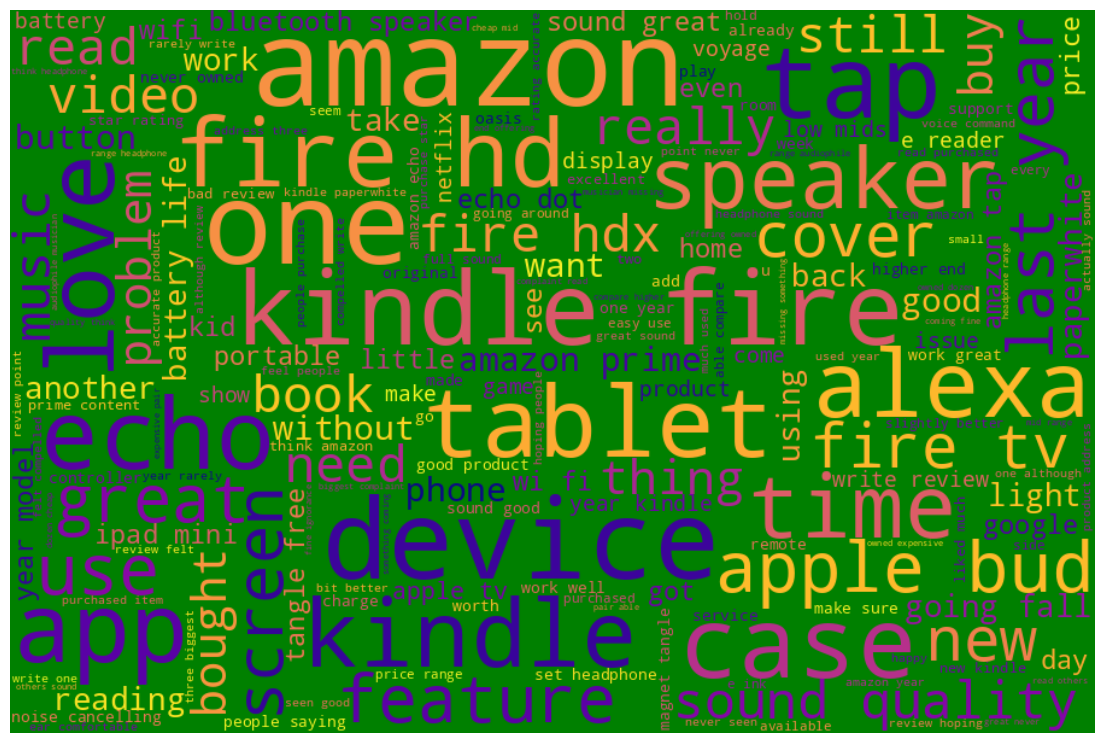

In [92]:
all_words = ' '.join([text for text in dataframe['Clean_Reviews'][dataframe.emotion == 'pos']])
generate_wordcloud(all_words)

**Unsatisfactory Feedbacks**

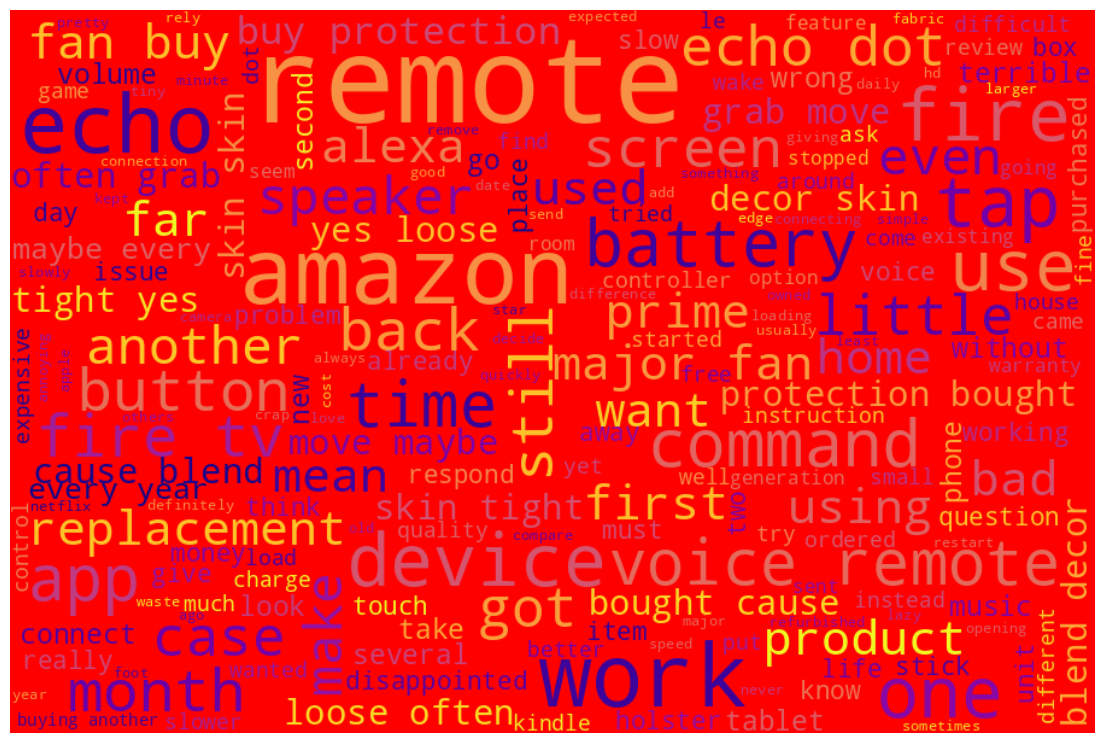

In [95]:
all_words = ' '.join([text for text in dataframe['Clean_Reviews'][dataframe.emotion == 'neg']])
generate_wordcloud(all_words)